In [ ]:
# !pip3 install statsmodels

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/jupyter-1.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/QtPy-2.4.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qtconsole-5.6.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [53]:
#!pip3 install xgboost

In [58]:
#!pip3 install prophet

In [61]:
#!pip3 install openai

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import openai
import json
import plotly.express as px

# FUNCTIONS

# 1. Data Preprocessing

In [71]:
# Loading the datasets
df_2022 = pd.read_csv('final_data_2022_weekly.csv')
df_2023 = pd.read_csv('final_data_2023_weekly.csv')
df_2024 = pd.read_csv('final_data_2024_weekly.csv')

# Function to reshape the data to long format
def melt_sales_df(df):
    df_long = df.melt(
        id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
        var_name='period',
        value_name='sales'
    )
    # Extract the start date from the '2022-01-01 to 2022-01-07' format
    df_long['period'] = df_long['period'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    df_long['period'] = pd.to_datetime(df_long['period'])
    return df_long

In [72]:
# Reshaping all datasets
df_2022_long = melt_sales_df(df_2022)
df_2023_long = melt_sales_df(df_2023)
df_2024_long = melt_sales_df(df_2024)

# Concatenating into one dataframe
df = pd.concat([df_2022_long, df_2023_long, df_2024_long])
df = df.sort_values('period').reset_index(drop=True)

In [82]:
df

,Seller,Brand,Discount,Rating,period,sales,avg_temp
0,000,ELENS KIDS,43.1,5.0,2021-12-27,0,3.715352
1,ИП Терпогосов Ашот Ашотович,TM-Shop,21.3,0.0,2021-12-27,0,8.645711
2,ИП Татарчук Руслан,DAMIANYANG,69.9,4.5,2021-12-27,0,4.496500
3,ИП Тарасюк О,OXY&XAD,30.0,4.2,2021-12-27,3,14.116826
4,ИП Тарасенко Иван Александрович,BOOGIE WOOGIE,43.8,0.0,2021-12-27,0,19.022285
...,...,...,...,...,...,...,...
382072,ИП Варданян З А,Vanshoes,80.4,4.2,2025-03-31,0,17.589215
382073,ИП Варданян К З,KAR&ORIGINAL,86.3,4.1,2025-03-31,0,-4.303997
382074,ИП Варданян К З,ShoeLend,86.6,3.6,2025-03-31,0,21.166721
382075,ИП Голубева А А,ANGO shoes,72.7,3.5,2025-03-31,0,23.318980


In [86]:
df.columns

Index(['Seller', 'Brand', 'Discount', 'Rating', 'period', 'sales', 'avg_temp'], dtype='object')

In [87]:
# Group by 'Seller' and sum the 'sales'
seller_sales = df.groupby('Seller')['sales'].sum()

# Identify the seller with the maximum sales
top_seller = seller_sales.idxmax()
max_sales = seller_sales.max()

print(f"The seller with the most sales is {top_seller} with {max_sales} sales.")


The seller with the most sales is ООО Ошейд with 38721 sales.


# 2. Integrating Weather Data

In [73]:
# Function to get weather data
def get_weather_data(start_date, end_date, city='Moscow', api_key='YOUR_OPENWEATHERMAP_API_KEY'):
    url = f"http://api.openweathermap.org/data/2.5/onecall/timemachine"
    # Convert dates to UNIX format
    start_timestamp = int(pd.to_datetime(start_date).timestamp())
    end_timestamp = int(pd.to_datetime(end_date).timestamp())

    # Fetch weather data for each day in the range
    weather_data = []
    for timestamp in range(start_timestamp, end_timestamp, 86400):  # 86400 seconds in a day
        response = requests.get(url, params={
            'lat': 55.7558,  # Moscow
            'lon': 37.6176,
            'dt': timestamp,
            'appid': api_key
        })
        data = response.json()
        avg_temp = data['current']['temp'] - 273.15  # Convert from Kelvin to Celsius
        weather_data.append(avg_temp)

    return weather_data

In [74]:
# Adding weather data to the main dataframe
# Use the get_weather_data function for each row (if API is not available, we use mock data)
df['avg_temp'] = np.random.normal(10, 10, size=len(df))  # Mock data in case of no API connection

In [88]:
# Select a seller for forecasting
seller_df = df[df['Seller'] == 'ООО Ошейд'][['period', 'sales']]
seller_df = seller_df.groupby('period').sum().reset_index()
seller_df = seller_df.rename(columns={'period': 'ds', 'sales': 'y'})

In [85]:
seller_df

,ds,y
0,2024-04-01,0
1,2024-04-08,0
2,2024-04-15,0
3,2024-04-22,0
4,2024-04-29,0
5,2024-05-06,0
6,2024-05-13,0
7,2024-05-20,0
8,2024-05-27,0
9,2024-06-03,0


In [78]:
seller_df.dropna(inplace=True)

In [79]:
seller_df.fillna(method='ffill', inplace=True)

/var/folders/8g/6w44yzyx161g_vkdv42_dfjc0000gn/T/ipykernel_1776/2129961348.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seller_df.fillna(method='ffill', inplace=True)


In [80]:
seller_df['ds'] = pd.to_datetime(seller_df['ds'])

## Prophet model

In [89]:
model = Prophet()
model.fit(seller_df)

17:31:53 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
# Forecasting
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

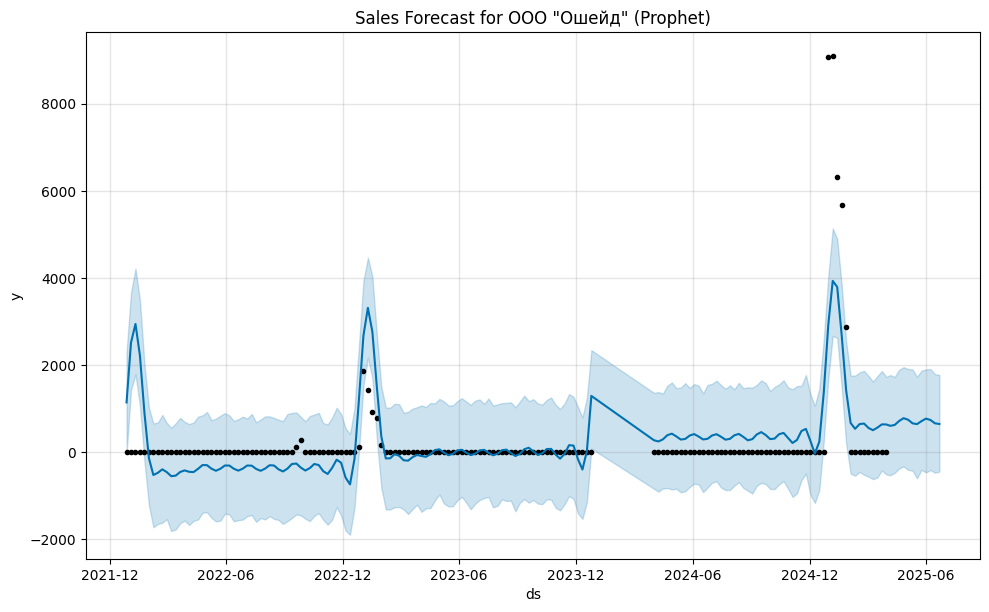

In [92]:
# Visualization
model.plot(forecast)
plt.title('Sales Forecast for ООО "Ошейд" (Prophet)')
plt.show()

## XGBoost

In [93]:
ml_df = df.groupby(['Seller', 'period']).agg({
    'Discount': 'mean',
    'Rating': 'mean',
    'avg_temp': 'mean',
    'sales': 'sum'
}).reset_index()

In [94]:
# Select one seller for demonstration
ml_data = ml_df[ml_df['Seller'] == 'ООО Ошейд'].drop(columns=['Seller'])

In [95]:
X = ml_data[['Discount', 'Rating', 'avg_temp']]
y = ml_data['sales']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [ ]:
# # XGBoost model
# model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)
# model_xgb.fit(X_train, y_train)

In [ ]:
# # Forecasting
# y_pred_xgb = model_xgb.predict(X_test)

In [ ]:
# Model evaluation
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGBoost RMSE:", rmse_xgb)

In [97]:
# Average rating and sales by each seller
seller_stats = df.groupby('Seller').agg({
    'sales': 'sum',
    'Rating': 'mean',
    'Discount': 'mean'
}).reset_index().sort_values('sales', ascending=False)

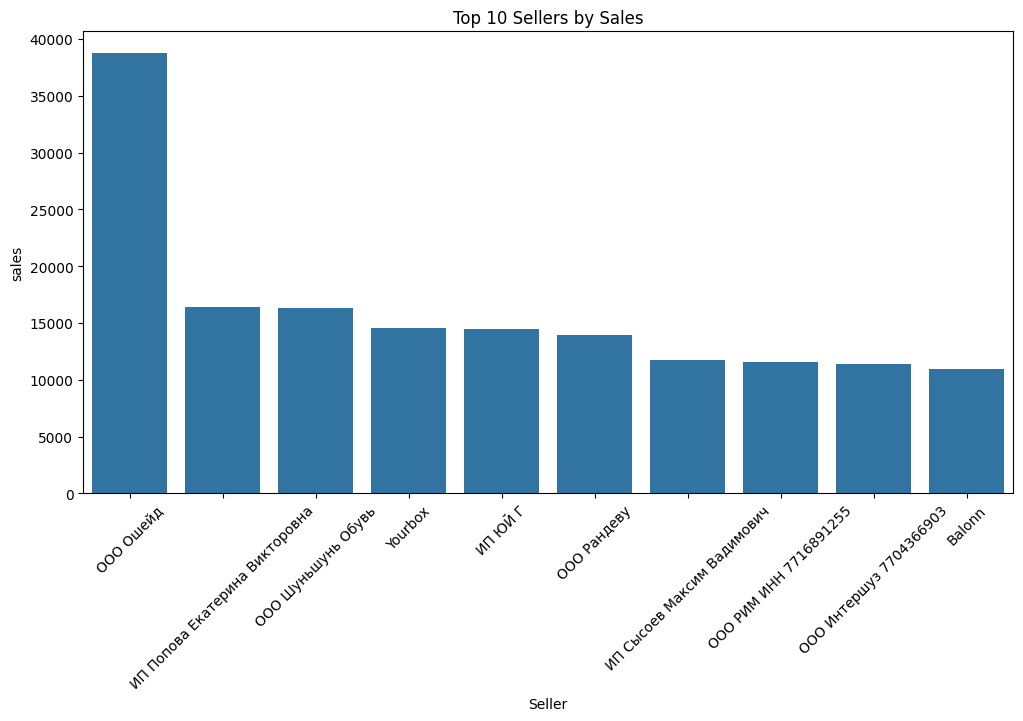

In [98]:
# Visualization
plt.figure(figsize=(12,6))
sns.barplot(data=seller_stats.head(10), x='Seller', y='sales')
plt.xticks(rotation=45)
plt.title('Top 10 Sellers by Sales')
plt.show()

##  OpenAI API configuration

In [99]:
openai.api_key = 'YOUR_OPENAI_API_KEY'

In [100]:
# Function to interact with LLM
def ask_llm(question):
    response = openai.ChatCompletion.create(
        model='gpt-4',
        messages=[
            {"role": "system", "content": "You are an expert in data analysis and e-commerce."},
            {"role": "user", "content": question}
        ]
    )
    return response['choices'][0]['message']['content']

In [101]:
# Example query
response = ask_llm("What could be the reasons for a drop in sales for Seller_A in January 2023?")
print(response)

APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [104]:
# Example interactive sales plot for one seller
fig = px.line(seller_df, x='ds', y='y', title='Sales for "ООО Ошейд" Over Time')
fig.show()

# Interactive plot for competition analysis
fig2 = px.bar(seller_stats.head(10), x='Seller', y='sales', title='Top 10 Sellers by Sales')
fig2.show()

# Exporting forecasted values to CSV
forecast.to_csv('forecast_sales_seller_a.csv', index=False)

# Saving the XGBoost model
import joblib
joblib.dump(model_xgb, 'xgboost_model.pkl')

NameError: name 'model_xgb' is not defined